# Spectral plots 

This notebook makes the spectral plots for the cfb on ebf manuscript.

The goal is to have several plots (each comparing WC to NC) including:
1) KE spectrum as a function of day (showing the increase of high wavenumbers)
2) Surf buoyancy gradient spectrum (presumably showing decrease of high-wavenumber gradients in WC case).

Maybe the ogives too if that is easier to see differences

Author: Jacob Wenegrat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
import xgcm
from glob import glob
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer
    
import xrft
from importlib import reload  
import sys
sys.path.append("../src/")
import load_model_runs as lruns
#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'



In [3]:
# reload(lruns)
# dsOLD, gridOLD = lruns.loadRun('../data/model/jet_his_20_NC.nc', chunks={'s_rho':10, 's_w':10}, old=True)
# dsOLD

In [3]:
## LOAD THE NEW RUNS
reload(lruns)
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks={'time':1})

#dsWC['f'] = dsOLD.f

reload(lruns)
# dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks={'time':1})

#dsNC['f'] = dsOLD.f

folder = '/data/pacific/jacob/CFB/cfb_on_ebf/figures/jet_ml_figs/'

In [4]:
# Vorticity Calculation
vx = gridNC.derivative(dsNC.v, 'X')
uy = gridNC.derivative(dsNC.u, 'Y')
vy = gridNC.derivative(dsNC.v, 'Y', boundary='extend')
ux = gridNC.derivative(dsNC.u, 'X', boundary='extend')

dsNC['vort'] = vx - uy
dsNC['div'] = vy + ux
dsNC['strain'] = np.sqrt((xroms.to_rho(ux, gridNC)-xroms.to_rho(vy,gridNC))**2 + (xroms.to_rho(vx,gridNC) + xroms.to_rho(uy,gridNC))**2)

vx = gridWC.derivative(dsWC.v, 'X')
uy = gridWC.derivative(dsWC.u, 'Y')
vy = gridWC.derivative(dsWC.v, 'Y', boundary='extend')
ux = gridWC.derivative(dsWC.u, 'X', boundary='extend')

dsWC['vort'] = vx - uy
dsWC['div'] = vy + ux
dsWC['strain'] = vy - ux # Note the alternate possible strain rate def (below)
dsWC['strain'] = np.sqrt((xroms.to_rho(ux, gridWC)-xroms.to_rho(vy,gridWC))**2 + (xroms.to_rho(vx,gridWC) + xroms.to_rho(uy,gridWC))**2)

In [5]:
# Ekman vertical velocity calculation
tauy_x = xroms.to_rho(gridWC.derivative(dsWC.svstr, 'X'), gridWC)
taux_y = xroms.to_rho(gridWC.derivative(dsWC.sustr, 'Y'), gridWC)
we_WC = (tauy_x - taux_y)/(1024*dsWC.f)

## Kinetic energy spectrum

In [6]:
savefig = False

In [7]:
# pick 4 days and plot the KE spectrum


yl = slice(1499, 2501)
yl = slice(1199, 2201)
yl = slice(500, 3500)
u = xroms.to_rho(dsWC.u, gridWC).isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
u['xi_rho'] = u.xi_rho*500
u['eta_rho'] = u.eta_rho*500

v = xroms.to_rho(dsWC.v.isel(s_rho=-1), gridWC).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
v['xi_rho'] = v.xi_rho*500
v['eta_rho'] = v.eta_rho*500

u_nc = xroms.to_rho(dsNC.u.isel(s_rho=-1), gridNC).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
u_nc['xi_rho'] = u_nc.xi_rho*500
u_nc['eta_rho'] = u_nc.eta_rho*500
v_nc = xroms.to_rho(dsNC.v.isel(s_rho=-1), gridNC).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
v_nc['xi_rho'] = v_nc.xi_rho*500
v_nc['eta_rho'] = v_nc.eta_rho*500
#uiso2 = xrft.isotropic_power_spectrum(dsWC.u.isel(s_rho=-1), dim=['xi_u', 'eta_rho'])
uiso2 = xrft.isotropic_power_spectrum(u, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True)
viso2 = xrft.isotropic_power_spectrum(v, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True)
#uspec = xrft.power_spectrum(u, dim=['xi_rho', 'eta_rho'])
eke = 0.5*(uiso2 + viso2)

uiso2_nc = xrft.isotropic_power_spectrum(u_nc, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True)
viso2_nc = xrft.isotropic_power_spectrum(v_nc, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True)
#uspec = xrft.power_spectrum(u, dim=['xi_rho', 'eta_rho'])
eke_nc = 0.5*(uiso2_nc + viso2_nc)


/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [8]:
days = [361, 366, 371, 390]
days = [370]
for d in days:
    plt.loglog(eke.freq_r,  eke.isel(ocean_time=slice(1, 100)).sel(ocean_time=d*86400, method='nearest'))
    plt.loglog(eke_nc.freq_r,  eke_nc.isel(ocean_time=slice(1, 100)).sel(ocean_time=d*86400, method='nearest'), linestyle='--')

    plt.axvline(1e-3)
    
plt.ylim(1e-6, 1e2)
#plt.xlim(1e-5, 1e-3)
plt.title('Surface KE')
plt.ylabel('PSD')
plt.xlabel('Wavenumber (1/m)')
plt.grid()

if savefig:
    plt.savefig(folder+'SurfKESpectra.pdf', bbox_inches='tight')

ValueError: cannot supply selection options {'method': 'nearest', 'tolerance': None} for dimension 'ocean_time'that has no associated coordinate or index

In [ ]:
timeslice = slice(380*86400, 391*86400)
plt.semilogx(eke.freq_r, eke.sel(ocean_time=timeslice).mean('ocean_time')/eke_nc.sel(ocean_time=timeslice).mean('ocean_time'))

plt.ylim(0.6, 1.2)
plt.xlim(eke.freq_r[0], 1/1e3)

In [ ]:
conts = np.arange(-0.45, 0.5, 0.1)

ekesmooth = eke.isel(ocean_time=slice(0,31)).rolling(ocean_time = 5, center=True).mean().rolling(freq_r=5, center=True).mean()
ekesmooth_nc = eke_nc.rolling(ocean_time = 5, center=True).mean().rolling(freq_r=5, center=True).mean()

#plt.pcolor(eke.ocean_time/86400, eke.freq_r, (eke/eke_nc).T-1, vmin=-0.4, vmax = 0.4, cmap='RdBu_r')
plt.contourf(ekesmooth.ocean_time/86400, eke.freq_r, (ekesmooth/ekesmooth_nc).T-1, conts, cmap='bwr', extend='both')

plt.yscale('log')
plt.ylim(eke.freq_r[1], 1e-3)


plt.colorbar()

In [27]:
eke.isel(ocean_time=slice(0,31))

<xarray.DataArray (ocean_time: 31, freq_r: 1002)>
dask.array<getitem, shape=(31, 1002), dtype=float64, chunksize=(1, 1002), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) float64 3.11e+07 3.119e+07 ... 3.361e+07 3.37e+07
    s_rho       float64 -0.005
  * freq_r      (freq_r) float64 8e-07 2.239e-06 3.686e-06 ... 0.001412 0.001413

In [36]:
conts = np.arange(-0.45, 0.5, 0.1)

conts

array([-0.45, -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,
        0.45])

In [58]:
# ogives
d = 360+30
nf = np.argmin(np.abs(eke.freq_r.values - 1e-3))
og = -integrate.cumtrapz(eke.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf],x=eke.freq_r.values[0:nf], initial=0) +  integrate.trapz(eke.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf], x=eke.freq_r[0:nf])

og_NC = -integrate.cumtrapz(eke_nc.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf],x=eke_nc.freq_r.values[0:nf], initial=0) +  integrate.trapz(eke_nc.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf], x=eke_nc.freq_r[0:nf])


/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing meth

Ratio of coupled to uncoupled KE: 0.828251799683529
Ratio of coupled to uncoupled KE LARGER: 0.9338327103920749


/tmp/ipykernel_11828/2540822376.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 100)


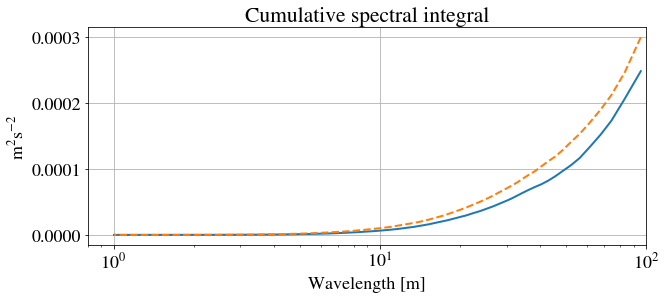

In [59]:
savefig=True
plt.rcParams['font.size'] = 18

ind = np.argmin(np.abs(eke.freq_r[:nf] - 1/1e5).values)

plt.figure(figsize=(10,4))
plt.semilogx(1/eke.freq_r[ind:nf]/1000, og[ind:nf], linewidth=2)
plt.semilogx(1/eke.freq_r[ind:nf]/1000, og_NC[ind:nf], linewidth=2, linestyle='--')


print(f'Ratio of coupled to uncoupled KE: {og[ind]/og_NC[ind]}')
print(f'Ratio of coupled to uncoupled KE LARGER: {(og[0] -og[ind])/(og_NC[0] - og_NC[ind])}')

plt.xlabel('Wavelength [m]')
plt.ylabel('m$^2$s$^{-2}$')
plt.title('Cumulative spectral integral')
plt.grid()
plt.xlim(0, 100)
if savefig:
    plt.savefig('../figures/SurfKESOgive.pdf', bbox_inches='tight')

## Temperature (buoyancy) spectrum

In [109]:
yl = slice(1000, 3000)
t = dsWC.rho.isel(s_rho=-1).isel(eta_rho=yl)
t['xi_rho'] = t.xi_rho*500
t['eta_rho'] = t.eta_rho*500
t=t.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
t_iso = xrft.isotropic_power_spectrum(t, dim=['xi_rho', 'eta_rho'], detrend='constant', window='hamming', nfactor=5, truncate=True)

t_nc = dsNC.rho.isel(s_rho=-1).isel(eta_rho=yl)
t_nc['xi_rho'] = t_nc.xi_rho*500
t_nc['eta_rho'] = t_nc.eta_rho*500
t_nc=t_nc.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
t_iso_nc = xrft.isotropic_power_spectrum(t_nc, dim=['xi_rho', 'eta_rho'], detrend='constant', window='hamming', nfactor=5, truncate=True)



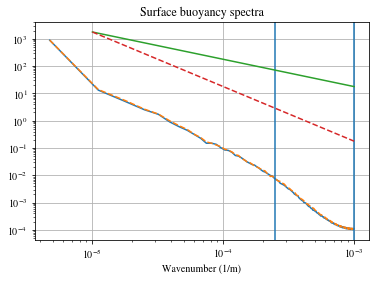

In [30]:
days = [370]
exp = 0
for d in days:
    spec = (t_iso.freq_r**exp*t_iso.isel(ocean_time=slice(1, 100)).sel(ocean_time=d*86400, method='nearest')).values
    plt.loglog(t_iso.freq_r,  spec)
    plt.loglog(t_iso_nc.freq_r,  t_iso_nc.freq_r**exp*t_iso_nc.isel(ocean_time=slice(1, 100)).sel(ocean_time=d*86400, method='nearest'), linestyle='--')

    plt.axvline(1e-3)
    plt.axvline(1/(4e3))
    
#plt.ylim(1e-8, 1e-2)

k3 = np.array([1e-5,1e-3])
E3 = 1/k3**3
E3 = E3/E3[0]*(np.max(spec)*2)
E2 = k3*E3
E2 = E2/E2[0]*E3[0]
E1 = k3*E2
E1 = E1/E1[0]*E3[0]
plt.plot(k3, E1)
plt.plot(k3, E2, linestyle='--')
plt.grid()
plt.title('Surface buoyancy spectra')
plt.xlabel('Wavenumber (1/m)')
if savefig:
    plt.savefig(folder+'SurfBuoySpectra.pdf', bbox_inches='tight')

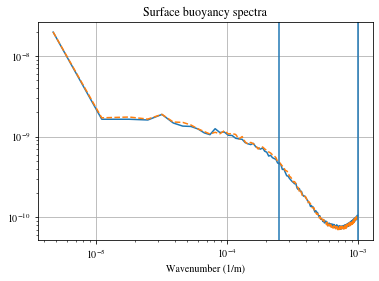

In [9]:
days = [370]
exp = 2
for d in days:
    spec = (t_iso.freq_r**exp*t_iso.isel(ocean_time=slice(1, 100)).sel(ocean_time=d*86400, method='nearest')).values
    plt.loglog(t_iso.freq_r,  spec)
    plt.loglog(t_iso_nc.freq_r,  t_iso_nc.freq_r**exp*t_iso_nc.isel(ocean_time=slice(1, 100)).sel(ocean_time=d*86400, method='nearest'), linestyle='--')

    plt.axvline(1e-3)
    plt.axvline(1/(4e3))
    
#plt.ylim(1e-8, 1e-2)

k3 = np.array([1e-5,1e-3])
E3 = 1/k3**3
E3 = E3/E3[0]*(np.max(spec)*2)
E2 = k3*E3
E2 = E2/E2[0]*E3[0]
E1 = k3*E2
E1 = E1/E1[0]*E3[0]
#plt.plot(k3, E1)
#plt.plot(k3, E2, linestyle='--')
plt.grid()
plt.title('Surface buoyancy spectra')
plt.xlabel('Wavenumber (1/m)')
if savefig:
    plt.savefig(folder+'SurfBuoySpectra.pdf', bbox_inches='tight')

In [114]:
# ogives
d = 385
nf = np.argmin(np.abs(t_iso.freq_r.values - 1e-3))
exp = 2
t_og = -integrate.cumtrapz(t_iso.freq_r[0:nf]**exp*t_iso.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf],x=t_iso.freq_r.values[0:nf], initial=0) +  integrate.trapz(t_iso.freq_r[0:nf]**exp*t_iso.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf], x=t_iso.freq_r[0:nf])
t_og_nc = -integrate.cumtrapz(t_iso.freq_r[0:nf]**exp*t_iso_nc.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf],x=t_iso.freq_r.values[0:nf], initial=0) +  integrate.trapz(t_iso.freq_r[0:nf]**exp*t_iso_nc.isel(ocean_time=slice(1,100)).sel(ocean_time=d*86400, method='nearest').values[0:nf], x=t_iso.freq_r[0:nf])



In [116]:
# ogives time averaged
d = 385
nf = np.argmin(np.abs(t_iso.freq_r.values - 1e-3))
exp = 2
ot = slice(1,30)
t_og = -integrate.cumtrapz(t_iso.freq_r[0:nf]**exp*t_iso.isel(ocean_time=ot).mean('ocean_time').values[0:nf],x=t_iso.freq_r.values[0:nf], initial=0) +  integrate.trapz(t_iso.freq_r[0:nf]**exp*t_iso.isel(ocean_time=ot).mean('ocean_time').values[0:nf], x=t_iso.freq_r[0:nf])
t_og_nc = -integrate.cumtrapz(t_iso.freq_r[0:nf]**exp*t_iso_nc.isel(ocean_time=ot).mean('ocean_time').values[0:nf],x=t_iso.freq_r.values[0:nf], initial=0) +  integrate.trapz(t_iso.freq_r[0:nf]**exp*t_iso_nc.isel(ocean_time=ot).mean('ocean_time').values[0:nf], x=t_iso.freq_r[0:nf])



Ratio of WC to NC is: 0.9692110202450399


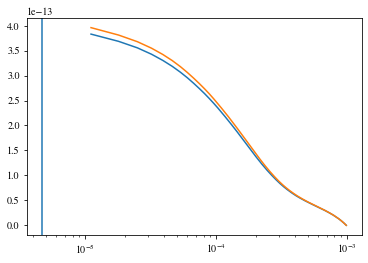

In [117]:
plt.semilogx(t_iso.freq_r[1:nf], t_og[1:])
plt.semilogx(t_iso.freq_r[1:nf], t_og_nc[1:])

# Add spectral fits
wavelength = 10000e3
ind = np.argmin(np.abs(t_iso.freq_r.values - 1/wavelength))
print(f'Ratio of WC to NC is: {t_og[ind]/t_og_nc[ind]}')
plt.axvline(t_iso.freq_r[ind])

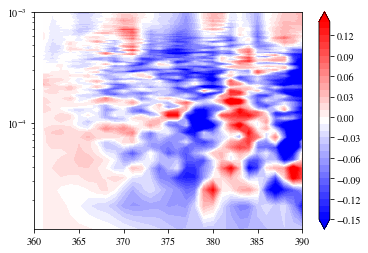

In [79]:
conts = np.arange(-0.15, .15, 0.01)
sm = 2

ekesmooth = t_iso.rolling(ocean_time = sm, center=True).mean().rolling(freq_r=sm, center=True).mean().isel(ocean_time=slice(0,31))
ekesmooth_nc = t_iso_nc.rolling(ocean_time = sm, center=True).mean().rolling(freq_r=sm, center=True).mean()

#plt.pcolor(eke.ocean_time/86400, eke.freq_r, (eke/eke_nc).T-1, vmin=-0.4, vmax = 0.4, cmap='RdBu_r')
plt.contourf(t_iso.ocean_time[0:31]/86400, t_iso.freq_r, (ekesmooth/ekesmooth_nc).T-1, levels=conts,cmap='bwr', extend='both')

plt.yscale('log')
plt.ylim(t_iso.freq_r[1], 1e-3)


plt.colorbar()

In [60]:
t_iso

<xarray.DataArray (ocean_time: 46, freq_r: 141)>
dask.array<getitem, shape=(46, 141), dtype=float64, chunksize=(1, 141), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
    s_rho       float64 -0.005
    time        (ocean_time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
  * freq_r      (freq_r) float64 4.721e-06 1.109e-05 ... 0.0009864 0.0009935

## Vort, Div, Strain statistics

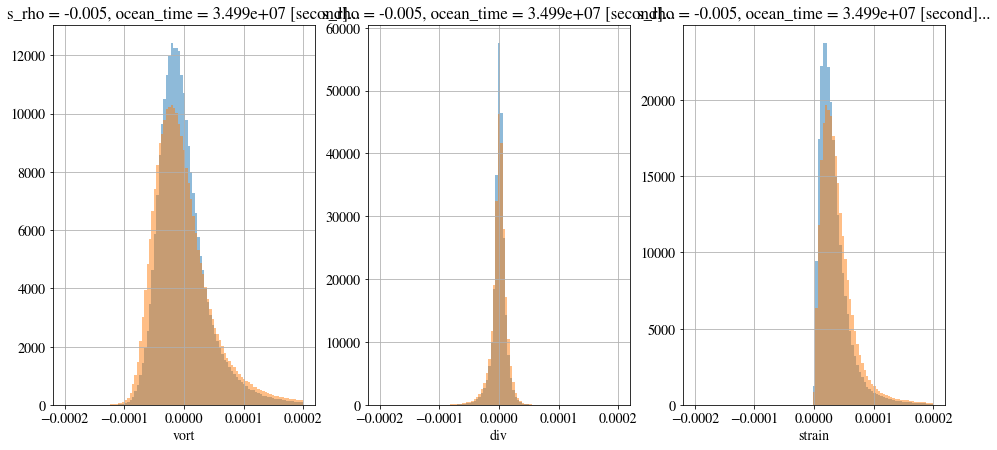

In [45]:
# Vorticity/Div/Strain Histogram
fig, ax = plt.subplots(1,3,figsize=(16,7), sharey=False)

sl = -15 # s_rho index to start at (goes to surface) -15 is z=100
sl = -1
#sl = -1
tl = -1  # time index to start at (goes to end)|
#yl = slice(750,1500)

dens = True # normalize
# Vorticity
bins = np.linspace(-2e-4, 2e-4, 100)
dsWC.vort.isel(s_rho=sl, ocean_time=tl, eta_v=yl).plot.hist(ax=ax[0], bins=bins, alpha=0.5, density=dens)
dsNC.vort.isel(s_rho=sl, ocean_time=tl, eta_v=yl).plot.hist(ax=ax[0], bins=bins, alpha=0.5, density=dens)
ax[0].grid()

# Div
dsWC.div.isel(s_rho=sl, ocean_time=tl, eta_rho=yl).plot.hist(ax=ax[1], bins=bins, alpha=0.5, density=dens)
dsNC.div.isel(s_rho=sl, ocean_time=tl, eta_rho=yl).plot.hist(ax=ax[1], bins=bins, alpha=0.5, density=dens)
ax[1].grid()

# Strain
dsWC.strain.isel(s_rho=sl, ocean_time=tl, eta_rho=yl).plot.hist(ax=ax[2], bins=bins, alpha=0.5, density=dens)
dsNC.strain.isel(s_rho=sl, ocean_time=tl, eta_rho=yl).plot.hist(ax=ax[2], bins=bins, alpha=0.5, density=dens)
ax[2].grid()

#ax[0].set_ylim(0, 2e5)

if savefig:
    plt.savefig(folder+'VortDivStrainHists.pdf', bbox_inches='tight')

In [50]:
# Calculate the spectrum of strain

strain = dsNC.strain.isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel( eta_rho=yl)
strain['xi_rho'] = strain.xi_rho*500
strain['eta_rho'] = strain.eta_rho*500
strain = strain.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
strain_NC = xrft.isotropic_power_spectrum(strain, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1)
strain = dsWC.strain.isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel( eta_rho=yl)
strain['xi_rho'] = strain.xi_rho*500
strain['eta_rho'] = strain.eta_rho*500
strain = strain.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
strain_WC = xrft.isotropic_power_spectrum(strain, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1)

# Calculate the spectrum of Vorticity

vort = dsNC.vort.isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_v':4002, 'xi_u':1002}).isel( eta_v=yl)
vort['xi_u'] = vort.xi_u*500
vort['eta_v'] = vort.eta_v*500
vort = vort.drop(['z_rho_psi', 'z_rho_psi0'])
vort_NC = xrft.isotropic_power_spectrum(vort, dim=['xi_u', 'eta_v'], detrend='linear', window=True, nfactor=1)

vort = dsWC.vort.isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_v':4002, 'xi_u':1002}).isel( eta_v=yl)
vort['xi_u'] = vort.xi_u*500
vort['eta_v'] = vort.eta_v*500
vort = vort.drop(['z_rho_psi', 'z_rho_psi0'])
vort_WC = xrft.isotropic_power_spectrum(vort, dim=['xi_u', 'eta_v'], detrend='linear', window=True, nfactor=1)


# Calculate the spectrum of Divergence

div = dsNC.div.isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel( eta_rho=yl)
div['xi_rho'] = div.xi_rho*500
div['eta_rho'] = div.eta_rho*500
div = div.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
div_NC = xrft.isotropic_power_spectrum(div, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1)

div = dsWC.div.isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel( eta_rho=yl)
div['xi_rho'] = div.xi_rho*500
div['eta_rho'] = div.eta_rho*500
div = div.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
div_WC = xrft.isotropic_power_spectrum(div, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1)

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xrft/xrft.py:1041: FutureWarning: The flag `truncate` will be set to True by default in future version in order to truncate the isotropic wavenumber larger than the Nyquist wavenumber.
  warnings.warn(msg, FutureWarning)
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/xrft/xrft.py:1041: FutureWarning: The flag `truncate` will be set to True by default in future version in order to truncate the i

In [133]:
## Truncate all the spectra
ind = np.argmin(np.abs(div_WC.freq_r.values - 1e-3))
print(div_WC.freq_r[ind].values)

div_WC = div_WC.isel(freq_r=slice(0, ind+1))
div_NC = div_NC.isel(freq_r=slice(0, ind+1))
vort_WC = vort_WC.isel(freq_r=slice(0, ind+1))
vort_NC = vort_NC.isel(freq_r=slice(0, ind+1))
strain_WC = strain_WC.isel(freq_r=slice(0, ind+1))
strain_NC = strain_NC.isel(freq_r=slice(0, ind+1))

#print(div_WC.isel(freq_r=slice(0, ind+1)).freq_r[-1].values)

0.0009999571702084948


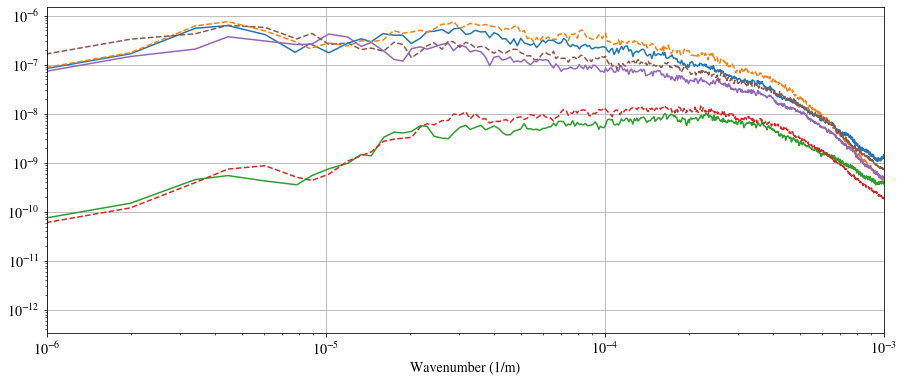

In [51]:
d = -1

plt.figure(figsize=(15,6))
plt.loglog(vort_WC.freq_r, vort_WC.isel(ocean_time=d))
plt.loglog(vort_NC.freq_r, vort_NC.isel(ocean_time=d), linestyle ='--')

plt.loglog(div_WC.freq_r, div_WC.isel(ocean_time=d))
plt.loglog(div_NC.freq_r, div_NC.isel(ocean_time=d), linestyle ='--')

plt.loglog(strain_WC.freq_r, strain_WC.isel(ocean_time=d))
plt.loglog(strain_NC.freq_r, strain_NC.isel(ocean_time=d), linestyle ='--')
plt.xlim(1e-6, 1e-3)
plt.grid()

plt.xlabel('Wavenumber (1/m)')

if savefig:
    plt.savefig(folder+'VortDivStrainSpectra.pdf', bbox_inches='tight')

Ratio of vorticity: 0.6855315323436771
Ratio of divergence: 0.7389806171351692
Ratio of strain: 0.7246809483930858


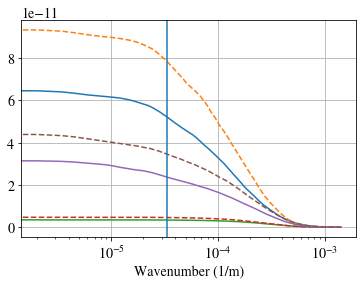

In [52]:
# Plot as Ogives
vortog_WC = -integrate.cumtrapz(vort_WC.isel(ocean_time=d),x=vort_WC.freq_r, initial=0) + integrate.trapz(vort_WC.isel(ocean_time=d), x=vort_WC.freq_r)
vortog_NC = -integrate.cumtrapz(vort_NC.isel(ocean_time=d),x=vort_NC.freq_r, initial=0) + integrate.trapz(vort_NC.isel(ocean_time=d), x=vort_NC.freq_r)
plt.semilogx(vort_WC.freq_r, vortog_WC)
plt.semilogx(vort_NC.freq_r, vortog_NC, linestyle='--')

divog_WC = -integrate.cumtrapz(div_WC.isel(ocean_time=d),x=div_WC.freq_r, initial=0) + integrate.trapz(div_WC.isel(ocean_time=d), x=div_WC.freq_r)
divog_NC = -integrate.cumtrapz(div_NC.isel(ocean_time=d),x=div_NC.freq_r, initial=0) + integrate.trapz(div_NC.isel(ocean_time=d), x=div_NC.freq_r)
plt.semilogx(div_WC.freq_r, divog_WC)
plt.semilogx(div_NC.freq_r, divog_NC, linestyle='--')

strainog_WC = -integrate.cumtrapz(strain_WC.isel(ocean_time=d),x=strain_WC.freq_r, initial=0) + integrate.trapz(strain_WC.isel(ocean_time=d), x=strain_WC.freq_r)
strainog_NC = -integrate.cumtrapz(strain_NC.isel(ocean_time=d),x=strain_NC.freq_r, initial=0) + integrate.trapz(strain_NC.isel(ocean_time=d), x=strain_NC.freq_r)

plt.semilogx(strain_WC.freq_r, strainog_WC)
plt.semilogx(strain_NC.freq_r, strainog_NC, linestyle='--')

plt.axvline(1/30e3)
plt.grid()
#plt.xlim(1e-5, 1e-3)
plt.xlabel('Wavenumber (1/m)')
wavelength = 100e3
ind = np.argmin(np.abs(strain_WC.freq_r.values - 1/wavelength))
print(f'Ratio of vorticity: {vortog_WC[ind]/vortog_NC[ind]}')
print(f'Ratio of divergence: {divog_WC[ind]/divog_NC[ind]}')
print(f'Ratio of strain: {strainog_WC[ind]/strainog_NC[ind]}')


## WIND WORK

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


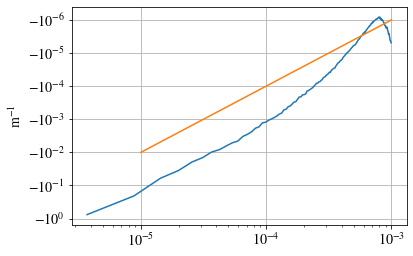

In [114]:
# Wind Work spectrum as Co Spectra


dstemp = dsWC.copy()
# dstemp['xi_rho'] = dstemp['xi_rho']*500
# dstemp['eta_rho'] = dstemp['eta_rho']*500
# dstemp['xi_u'] = dstemp['xi_u']*500
# dstemp['eta_v'] = dstemp['eta_v']*500

# Wind work
TS = 30 # pick timestep

uvel = xroms.to_rho(dstemp.u.isel(s_rho=-1, ocean_time=TS), gridWC).chunk({ 'eta_rho':4002, 'xi_rho':1002})
ustress = xroms.to_rho(dstemp.sustr.isel(ocean_time=TS)/1024, gridWC).chunk({'eta_rho':4002, 'xi_rho':1002})
#uvel = dstemp.u.isel(s_rho=-1, ocean_time=TS).drop(['z_rho_u', 'z_rho_u0'])
#ustress = dstemp.sustr.isel(ocean_time=TS)/1024
vvel = xroms.to_rho(dstemp.v.isel(s_rho=-1, ocean_time=TS), gridWC).chunk({ 'eta_rho':4002, 'xi_rho':1002})
vstress = xroms.to_rho(dstemp.svstr.isel(ocean_time=TS)/1024, gridWC).chunk({'eta_rho':4002, 'xi_rho':1002})
txw_spec  = xrft.isotropic_cross_spectrum(uvel, ustress, detrend='linear', window='hamming', truncate=True, true_phase=True)
tyw_spec  = xrft.isotropic_cross_spectrum(vvel, vstress, detrend='linear', window='hamming', truncate=True, true_phase=True)
txw_spec['freq_r'] = txw_spec.freq_r/500
wwspec_WC = txw_spec.values# + tyw_spec.values #XXX NOTE THIS IS A HACK< NEED TO ALIGN COORDS FIRST

dstemp['xi_rho'] = dstemp['xi_rho']*500
dstemp['eta_rho'] = dstemp['eta_rho']*500
dstemp['xi_u'] = dstemp['xi_u']*500
dstemp['eta_v'] = dstemp['eta_v']*500
#txw_spec2  = xrft.isotropic_cross_spectrum(dstemp.u.isel(s_rho=-1, ocean_time=TS).drop(['z_rho_u', 'z_rho_u0']), dstemp.sustr.isel(ocean_time=TS), detrend='linear', window='hamming', truncate=True, true_phase=True)
#tyw_spec  = xrft.isotropic_cross_spectrum(dsNC.v.isel(s_rho=-1, ocean_time=TS).drop(['z_rho_v', 'z_rho_v0']), dsNC.svstr.isel(ocean_time=TS), detrend='linear')

#wwspec_NC = txw_spec2.values# + tyw_spec.values #XXX NOTE THIS IS A HACK< NEED TO ALIGN COORDS FIRST

plt.semilogx(txw_spec.freq_r, wwspec_WC*500**2) # XXX IS THIS RIGHT UNITS??
#plt.semilogx(txw_spec2.freq_r, wwspec_NC)

#plt.plot(dsNC.ocean_time/86400, ww_NC)
plt.ylabel('m$^{-1}$')
plt.grid()
plt.yscale('symlog', linthresh=1e-11)

k2 = np.array([1e-5,1e-3])
E2 = 1/k2**2
E2 = E2/E2[0]*(-1)*1e-2
plt.plot(k2, E2)

#plt.ylim(-1e-3,0)

In [94]:
txw_spec.freq_r


<xarray.DataArray 'freq_r' (freq_r: 0)>
array([], dtype=float64)
Coordinates:
  * freq_r   (freq_r) float64

## VBP spectrum

In [24]:
# VBP spectrum as Co Spectra


dstemp = dsWC.copy()
yl = slice(1500, 2500)
w = xroms.to_rho(dstemp.w, gridWC)
w['xi_rho'] = w['xi_rho']*500
w['eta_rho'] = w['eta_rho']*500

b = -9.8*dstemp.rho/1024
b['xi_rho'] = b['xi_rho']*500
b['eta_rho'] = b['eta_rho']*500
TS = 10 # pick timestep


mld = dstemp.hbl.isel(ocean_time=TS, eta_rho=yl).mean(('eta_rho', 'xi_rho'))
SR = np.argmin(np.abs(dsWC.z_rho0.mean(('eta_rho', 'xi_rho')).values + mld.values/2))
print(mld.values)
txw_spec  = xrft.isotropic_cross_spectrum(w.isel(s_rho=SR, ocean_time=TS, eta_rho=yl).drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0']), b.isel(s_rho=SR, ocean_time=TS, eta_rho=yl).drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0']), detrend='constant', window='hamming', truncate=True, true_phase=True)
wbspec_WC = txw_spec.values 

dstemp = dsNC.copy()

w = xroms.to_rho(dstemp.w, gridWC)
w['xi_rho'] = w['xi_rho']*500
w['eta_rho'] = w['eta_rho']*500

b = -9.8*dstemp.rho/1024
b['xi_rho'] = b['xi_rho']*500
b['eta_rho'] = b['eta_rho']*500

txw_spec  = xrft.isotropic_cross_spectrum(w.isel(s_rho=SR, ocean_time=TS, eta_rho=yl).drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0']), b.isel(s_rho=SR, ocean_time=TS, eta_rho=yl).drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0']), detrend='constant', window='hamming', truncate=True, true_phase=True)
wbspec_NC = txw_spec.values 


24.832182


/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


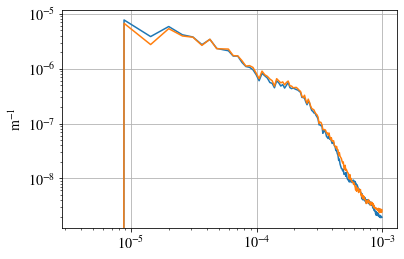

In [7]:

plt.loglog(txw_spec.freq_r, wbspec_WC)
plt.loglog(txw_spec.freq_r, wbspec_NC)

#plt.semilogx(txw_spec.freq_r, wwspec_NC)

#plt.plot(dsNC.ocean_time/86400, ww_NC)
plt.ylabel('m$^{-1}$')
plt.grid()
#plt.yscale('symlog', linthresh=1e-9)

#k2 = np.array([1e-5,1e-3])
#E2 = 1/k3**2
#E2 = E2/E2[0]*(-1)
#plt.plot(k2, E2)

#plt.ylim(-1e-3,0)

Ratio of coupled to uncoupled KE: (0.870427444200034-6.195819660861152e-17j)
Ratio of coupled to uncoupled KE LARGER: (0.9562622188281171+9.601705660636452e-17j)


/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


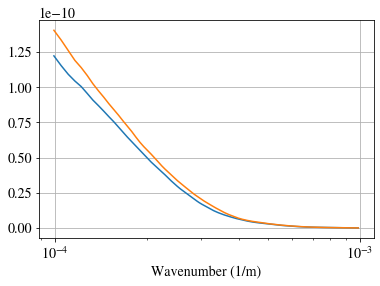

In [26]:
# ogives
savefig=False
d = 370
nf = np.argmin(np.abs(txw_spec.freq_r.values - 1e-3))
og = -integrate.cumtrapz(wbspec_WC,x=txw_spec.freq_r.values, initial=0) +  integrate.trapz(wbspec_WC[:], x=txw_spec.freq_r[:])
og_NC = -integrate.cumtrapz(wbspec_NC,x=txw_spec.freq_r.values, initial=0) +  integrate.trapz(wbspec_NC, x=txw_spec.freq_r)



ind = np.argmin(np.abs(txw_spec.freq_r[:] - 1e-4).values)

plt.semilogx(txw_spec.freq_r[ind:nf], og[ind:nf])
plt.semilogx(txw_spec.freq_r[ind:nf], og_NC[ind:nf])


print(f'Ratio of coupled to uncoupled KE: {og[ind]/og_NC[ind]}')
print(f'Ratio of coupled to uncoupled KE LARGER: {(og[0] -og[ind])/(og_NC[0] - og_NC[ind])}')

plt.xlabel('Wavenumber (1/m)')
plt.grid()

if savefig:
    plt.savefig(folder+'SurfKESOgive.pdf', bbox_inches='tight')

# VBP With Ekman vert velocity

In [22]:
txw_spec.freq_r[:] -1e-4

<xarray.DataArray 'freq_r' (freq_r: 176)>
array([-9.62550116e-05, -9.12094107e-05, -8.56934111e-05, -8.00582840e-05,
       -7.43665751e-05, -6.89264041e-05, -6.33403132e-05, -5.75715717e-05,
       -5.18936543e-05, -4.61856102e-05, -4.04891128e-05, -3.49508605e-05,
       -2.93203537e-05, -2.35901998e-05, -1.79099055e-05, -1.22109822e-05,
       -6.55878567e-06, -9.94587704e-07,  4.59370038e-06,  1.02904313e-05,
        1.59878722e-05,  2.16763470e-05,  2.73306415e-05,  3.28998508e-05,
        3.85531872e-05,  4.42730040e-05,  4.99510190e-05,  5.56234461e-05,
        6.12612336e-05,  6.68624994e-05,  7.25150343e-05,  7.82146061e-05,
        8.38751573e-05,  8.95505102e-05,  9.52204064e-05,  1.00842668e-04,
        1.06485052e-04,  1.12135496e-04,  1.17811615e-04,  1.23501555e-04,
        1.29150953e-04,  1.34757330e-04,  1.40417947e-04,  1.46109623e-04,
        1.51782016e-04,  1.57442341e-04,  1.63077411e-04,  1.68713657e-04,
        1.74363543e-04,  1.80032562e-04,  1.85694265e-04,  1.91340935e-04,
        1.96999673e-04,  2.02647515e-04,  2.08301478e-04,  2.13981351e-04,
        2.19645786e-04,  2.25296676e-04,  2.30954969e-04,  2.36606773e-04,
        2.42252823e-04,  2.47919394e-04,  2.53582609e-04,  2.59240717e-04,
        2.64905013e-04,  2.70564645e-04,  2.76203962e-04,  2.81869015e-04,
        2.87541259e-04,  2.93180270e-04,  2.98828731e-04,  3.04495192e-04,
        3.10129974e-04,  3.15788126e-04,  3.21464745e-04,  3.27102081e-04,
        3.32751395e-04,  3.38423081e-04,  3.44079233e-04,  3.49734406e-04,
...
        4.45903926e-04,  4.51542603e-04,  4.57203669e-04,  4.62871563e-04,
        4.68523655e-04,  4.74185843e-04,  4.79847818e-04,  4.85480766e-04,
        4.91133718e-04,  4.96809655e-04,  5.02475595e-04,  5.08137363e-04,
        5.13796304e-04,  5.19438451e-04,  5.25081168e-04,  5.30741951e-04,
        5.36399398e-04,  5.42072478e-04,  5.47740824e-04,  5.53375929e-04,
        5.59022929e-04,  5.64693288e-04,  5.70361287e-04,  5.76020682e-04,
        5.81674942e-04,  5.87316247e-04,  5.92974693e-04,  5.98645662e-04,
        6.04293438e-04,  6.09949087e-04,  6.15592666e-04,  6.21236161e-04,
        6.26910111e-04,  6.32578978e-04,  6.38223475e-04,  6.43886345e-04,
        6.49546795e-04,  6.55186906e-04,  6.60847187e-04,  6.66520509e-04,
        6.72170278e-04,  6.77833874e-04,  6.83504048e-04,  6.89128984e-04,
        6.94787644e-04,  7.00470551e-04,  7.06123166e-04,  7.11780316e-04,
        7.17438723e-04,  7.23067673e-04,  7.28722038e-04,  7.34407825e-04,
        7.40053310e-04,  7.45702752e-04,  7.51350728e-04,  7.56987913e-04,
        7.62661507e-04,  7.68349189e-04,  7.73999446e-04,  7.79643352e-04,
        7.85304049e-04,  7.90944543e-04,  7.96603459e-04,  8.02287146e-04,
        8.07950004e-04,  8.13598055e-04,  8.19250300e-04,  8.24892430e-04,
        8.30547375e-04,  8.36221676e-04,  8.41888053e-04,  8.47530983e-04,
        8.53168553e-04,  8.58816778e-04,  8.64483423e-04,  8.70163818e-04,
        8.75823006e-04,  8.81470296e-04,  8.87114188e-04,  8.92759926e-04])
Coordinates:
    s_rho       float64 -0.035
    ocean_time  float64 3.154e+07
    time        float64 3.154e+07
  * freq_r      (freq_r) float64 3.745e-06 8.791e-06 ... 0.0009871 0.0009928

In [24]:
TS = 30 # pick timestep
yl = slice(1000, 3000)
mld = dsWC.hbl.isel(ocean_time=TS, eta_rho=yl).mean(('eta_rho', 'xi_rho'))
SR = np.argmin(np.abs(dsWC.z_rho0.mean(('eta_rho', 'xi_rho')).values + mld.values/2))

w = we_WC.chunk({'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002})
b = -9.8*dsWC.rho/1024
w['xi_rho'] = w['xi_rho']*500
w['eta_rho'] = w['eta_rho']*500
b['xi_rho'] = b['xi_rho']*500
b['eta_rho'] = b['eta_rho']*500
txw_spec  = xrft.isotropic_cross_spectrum(w.isel( ocean_time=TS, eta_rho=yl).drop(['x_rho', 'y_rho']), b.isel(s_rho=SR, ocean_time=TS, eta_rho=yl).drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0']), detrend='constant', window='hamming', truncate=True, true_phase=True)
wbspec_NC = txw_spec.values 





(-1e-07, 5e-07)

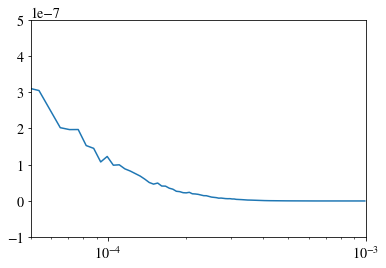

In [29]:
plt.semilogx(txw_spec.freq_r, txw_spec.values.real)
plt.xlim(5e-5, 1e-3)
plt.ylim(-1e-7, 5e-7)

## EXTRAS

In [ ]:
freq_r = np.sqrt(uspec.freq_eta_rho**2 +uspec.freq_xi_rho**2)
plt.figure(figsize=(10,12))
plt.pcolor(uspec.freq_eta_rho, uspec.freq_eta_rho, freq_r)
cb = plt.colorbar()
cb.set_label('freq$_r$')
plt.axis('equal')
plt.contour(uspec.freq_eta_rho, uspec.freq_eta_rho, freq_r, [0.5], colors='k', linewidth=2)
plt.xlabel('k')
plt.ylabel('l')


In [ ]:
plt.contour(uspec.freq_eta_rho, uspec.freq_eta_rho, freq_r, [0.5], colors='k', linewidth=2)
